<a href="https://colab.research.google.com/github/Yaroslav-Muravev/Homework_itmo_ML/blob/main/Homework_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EDA для "StockX Sneaker Data Contest"**


In [68]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [69]:
%cd gdrive/MyDrive/Dz_itmo_course

[Errno 2] No such file or directory: 'gdrive/MyDrive/Dz_itmo_course'
/content/gdrive/MyDrive/Dz_itmo_course


In [70]:
!pip install -r requirements.txt

ERROR: Could not find a version that satisfies the requirement warnings (from versions: none)
ERROR: No matching distribution found for warnings


In [71]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.cbook import boxplot_stats
import re
from datetime import date

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import max_error, mean_absolute_percentage_error
from xgboost.sklearn import XGBRegressor

В датасете представлено **100.000** покупок пар обуви и их цены.

Требуется пронализировать данный датасет, выделив наиболее важную информацию для бизнеса/ретейлеров.

In [81]:
data = pd.read_csv('StockX-Data-Contest-2019-3.csv')

#В датасете находятся некоторые данные в неправильном формате, поэтому их нужно преобразовать
#В данном случае используется лямбда функция со встроенным списочным выражением
#Проблем с переполнением и временем выполнения возникать не должно, так как количество элементов мало (всего лишь 10К)
#Если большой датасет, то в кэше нельзя хранить столбцы, а преобразовывать лучше через срезы

data = data.apply(lambda colomn: [int(''.join(re.split("[$,]", element_from_colomn))) for element_from_colomn in colomn] if colomn.name in ["Retail Price", "Sale Price"] else colomn)

data.head()

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
0,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,1097,220,9/24/16,11.0,California
1,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,685,220,11/23/16,11.0,California
2,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,690,220,11/23/16,11.0,California
3,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,1075,220,11/23/16,11.5,Kentucky
4,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,828,220,2/11/17,11.0,Rhode Island


In [82]:
data.describe()

,Sale Price,Retail Price,Shoe Size
count,99956.000000,99956.00000,99956.000000
mean,446.634719,208.61359,9.344181
std,255.982969,25.20001,2.329588
min,186.000000,130.00000,3.500000
25%,275.000000,220.00000,8.000000
50%,370.000000,220.00000,9.500000
75%,540.000000,220.00000,11.000000
max,4050.000000,250.00000,17.000000


In [83]:
sns.set(rc={'figure.figsize':(10, 8)})

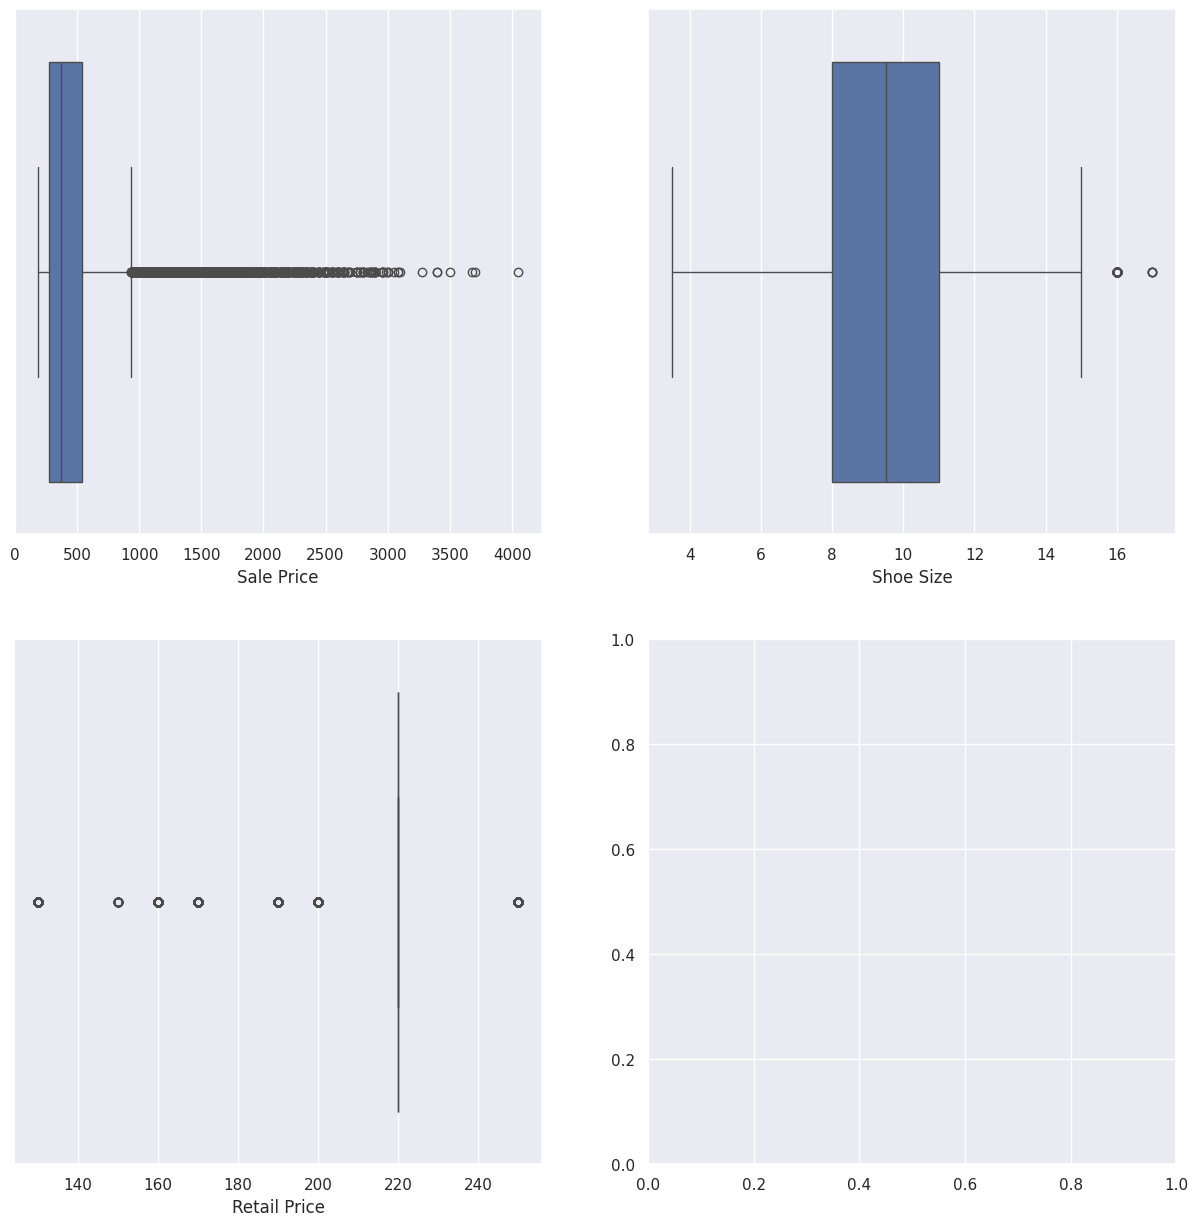

In [84]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
num_cols = ['Sale Price', 'Retail Price', 'Shoe Size']
count = 0
for idx, feature in enumerate(num_cols):
    sns.boxplot(x=data[feature], ax=axes[count % 2, count // 2])
    count += 1

По оценке выбросов видно, что розничная торговля сконцентрирована преимущественно в рамках продаж пар обуви по 220$. Сама цена продажи на рынке уже сильно варьируется, тут нельзя говорить о нескольких выбросах.

Для размера обуви выявлено две точки. Это не ошибка в сборе данных, такие размеры существуют и в данных их всего несколько точек.

<Axes: ylabel='Density'>

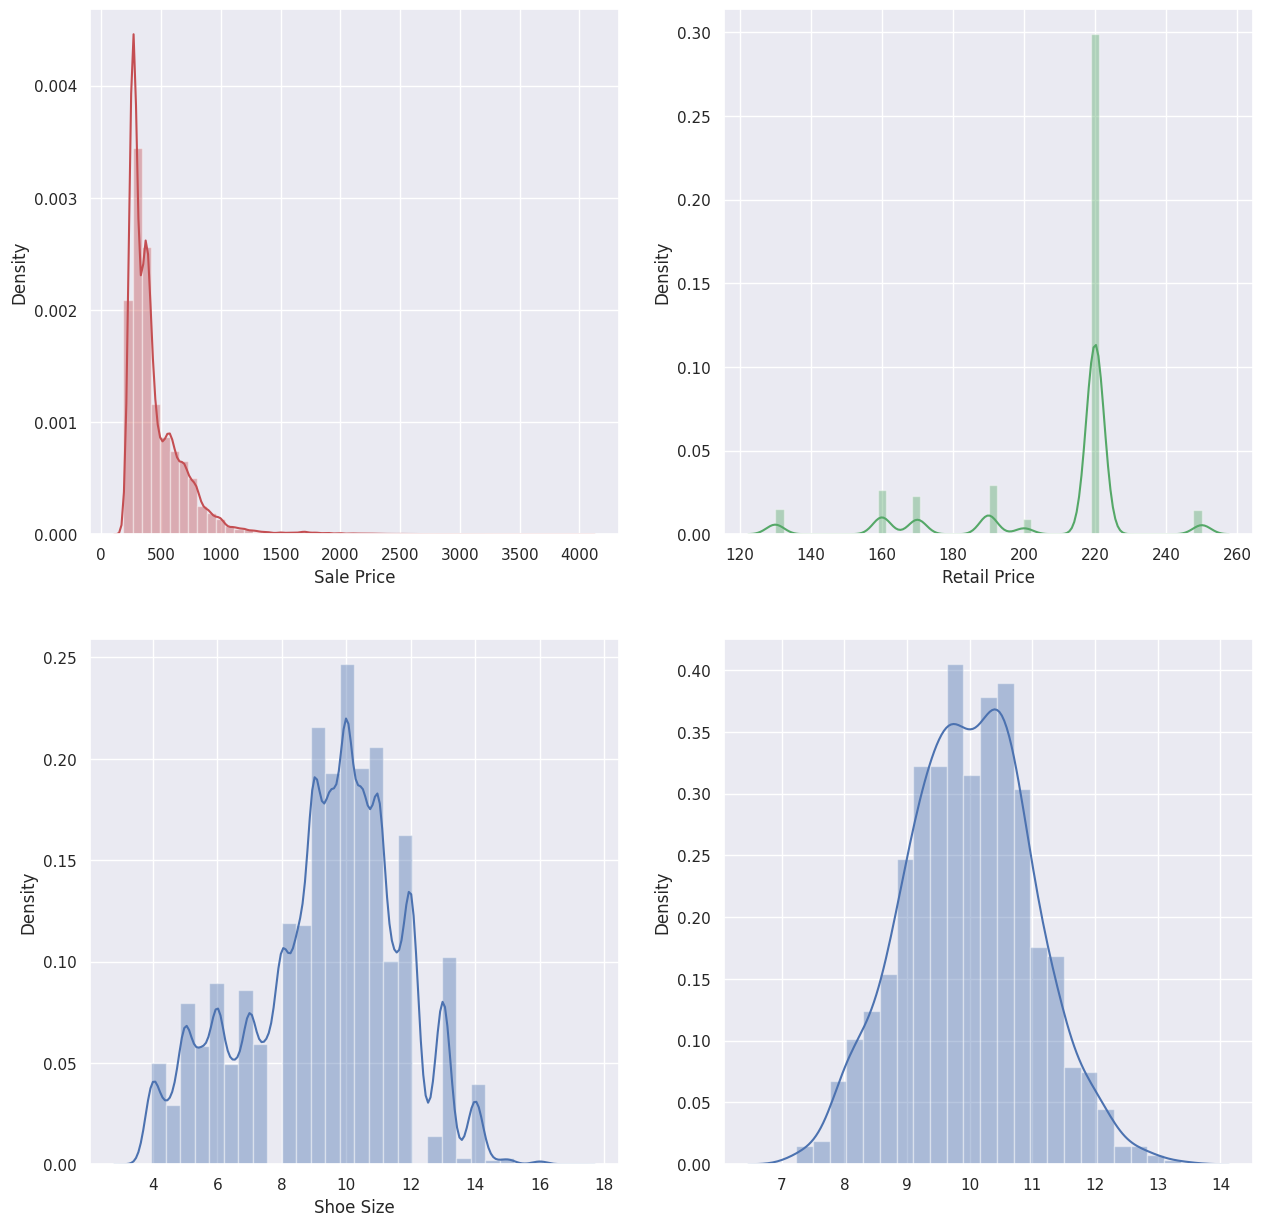

In [85]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
sns.distplot(data['Sale Price'], bins=50, color='r', ax=axes[0, 0])
sns.distplot(data['Retail Price'], bins=50, color='g', ax=axes[0, 1])
sns.distplot(data['Shoe Size'], bins=30, color='b', ax=axes[1, 0])
sns.distplot(np.random.normal(size=1000) + 10, color='b', ax=axes[1, 1])

По графикам можно заметить, что распределение размеров обуви схоже с нормальным. Это можно оценить. Так, мы сможем показать, присутствуют ли в выборке те, кто покупает на перепродажу. Таким образом, мы сможем отделить наших потенциальных покупателей (если собираемся закупать малое количество кроссовок)

\begin{equation}
  \begin{cases}
    H_{0} - распределение \ нормальное \\
    H_{1} - распределение \ не \ нормальное \\
  \end{cases}
\end{equation}

\begin{align}
  \dfrac{S_n - ES_n}{DS_n} \Rightarrow (при \ H_0) \ \mid \frac{S_n - N*\mu}{N\sigma^2} \mid \ \leq \ 1.65 \ (квантиль \ Z_{0.95})
\end{align}

38966 ≤ 934007 ≤ 1829870

Распределение нормальное, поэтому можно сказать, что пристуствует крайне малое количество тех, кто покупает на перепродажу.

Если говорить про цену продажи, то видно, что основная масса расположена в диапазоне от 186 до 600$. Так, возможно, для стабилизации прибыли с перепродажи необходимо будет исключить модели кроссовок, которые впоследствии сильно выросли в цене

In [86]:
make_shift = lambda lst, shift: lst[-shift:] + lst[:-shift]

for colomn_change_format_to_date in ["Order Date", "Release Date"]:
  data[colomn_change_format_to_date] = data[colomn_change_format_to_date].apply(lambda date_string: date(*make_shift([int(''.join(['20', part_of_date])) if num_part_of_date == 2 else int(part_of_date) for num_part_of_date, part_of_date in enumerate(date_string.split('/'))], 1)))


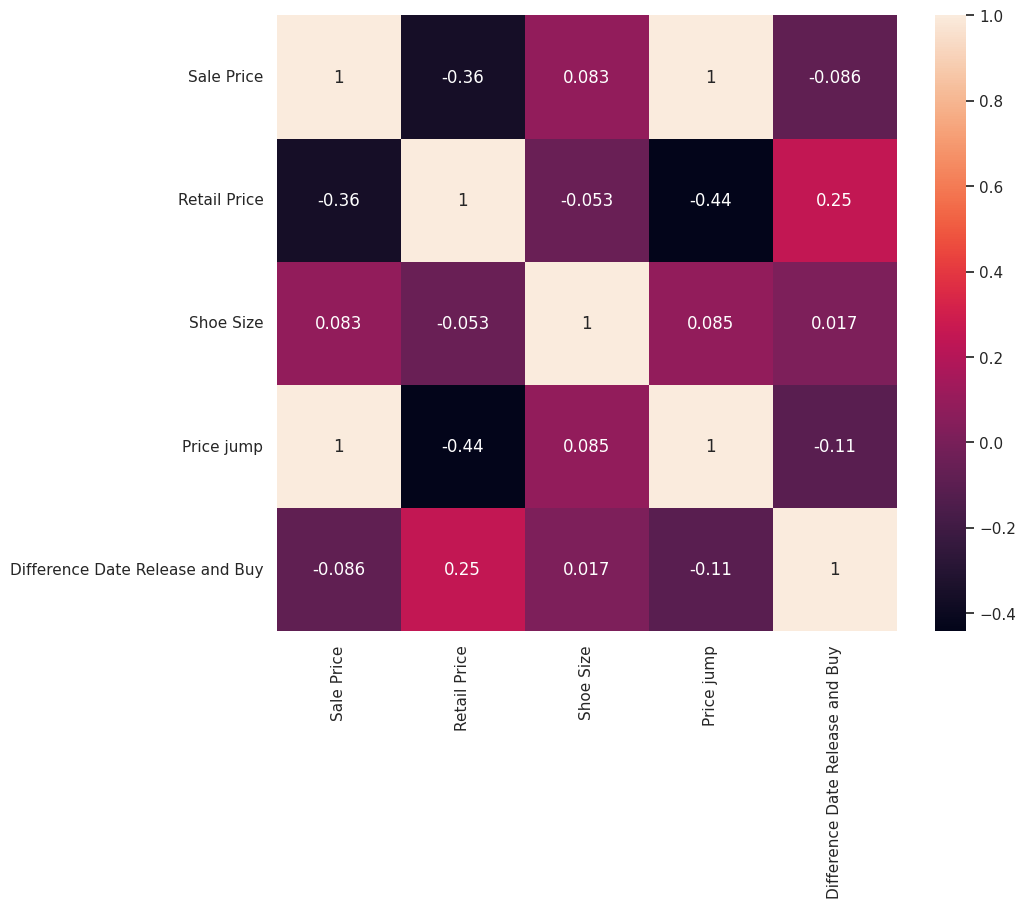

In [87]:
data["Price jump"] = data["Sale Price"] - data["Retail Price"]
data["Difference Date Release and Buy"] = data["Order Date"] - data["Release Date"]
data["Difference Date Release and Buy"] = pd.to_numeric(data["Difference Date Release and Buy"].dt.days, downcast='integer')

sns.heatmap(data.corr(), annot=True);

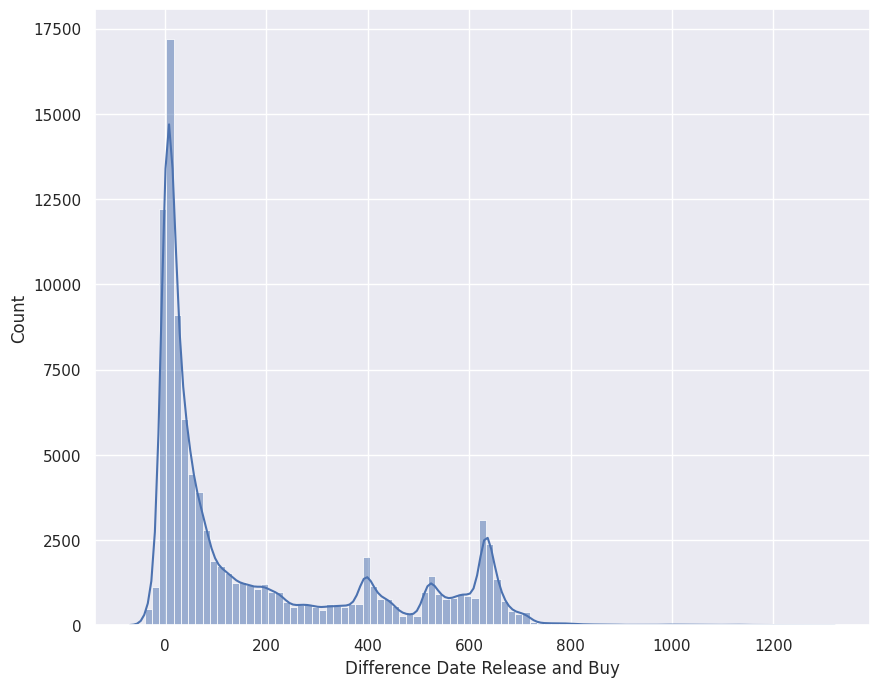

In [88]:
sns.histplot(x=data["Difference Date Release and Buy"], kde=True, kde_kws={'bw_adjust': 0.5});

По матрице корреляций можно сделать несколько выводов:

*   Размер обуви влияет на цену как таковую (и розничной продажи и обычной), но не сильно
*   Чем больше цена закупочная, тем меньше процентная наценка
*   Вместе с течением времени относительно выпуска коллекции увеличивается стоимость обуви

Некоторые выводы выглядят контринтуитивными, поэтому нужно проанализировать полученную таблицу. Например, 3. Ожидается, что с выпуском новой коллекции старая падает в цене, поэтому с течением времени цена может увеличиваться, но при этом будет и падать после какого-то момента. Скорее всего, это связано с методом построения самой таблицы. Нужно отслеживать динамику отдельных моделей, чтобы сделать более правдоподобный вывод.

Если принять таблицу верной, то уже сейчас можно предположить, что стоит продавать спустя 100 дней после выпуска, а также дешевые кроссовки. Про конкретную наценку сложно что-то сказать разумное.

Проверим данный вывод с помощью машинного обучения.

Ожидается, что модель будет получать на вход время релиза и будет выдавать время продажи обуви.

In [89]:
enc_brand = LabelEncoder()
enc_buyer = LabelEncoder()
enc_name = LabelEncoder()

brand_enc = enc_brand.fit(data["Brand"])
buyer_region_enc = enc_buyer.fit(data["Buyer Region"])
name_enc = enc_name.fit(data["Sneaker Name"])

In [94]:
regression_models = [
      ("Linear_regression", LinearRegression()),
      ("Gradient_boosting_regressor", GradientBoostingRegressor()),
      ("XGB_regressor", XGBRegressor())
]

for brand in brand_enc.classes_:
  data_only_cur_brand = data[data['Brand'] == brand]

  data_only_cur_brand = data_only_cur_brand.drop(["Order Date", "Release Date", "Brand"], axis=1)
  data_only_cur_brand = data_only_cur_brand.apply(lambda column: enc_buyer.transform(column) if column.name == "Buyer Region" else column)
  data_only_cur_brand = data_only_cur_brand.apply(lambda column: enc_name.transform(column) if column.name == "Sneaker Name" else column)

  x_train, x_test, y_train, y_test= train_test_split(data_only_cur_brand.drop(["Sale Price"], axis=1),
                                                    data_only_cur_brand["Sale Price"],
                                                    test_size=0.3,
                                                    random_state=42)
  max_error_list = []
  mape_list = []

  for model in regression_models:
    model[1].fit(x_train, y_train)
    max_error_list.append(max_error(y_test, model[1].predict(x_test)))
    mape_list.append(mean_absolute_percentage_error(y_test, model[1].predict(x_test)))

  metrics_result = pd.DataFrame({'Max error': max_error_list,
                               'MAPE': mape_list},
                               index=[model[0] for model in regression_models])
  print(brand)
  print(metrics_result)
  print()

 Yeezy
                                Max error          MAPE
Linear_regression            9.094947e-13  1.742932e-16
Gradient_boosting_regressor  3.053389e+02  1.992410e-03
XGB_regressor                6.320944e+02  2.157021e-03

Off-White
                                Max error          MAPE
Linear_regression            2.728484e-12  3.783211e-16
Gradient_boosting_regressor  1.129246e+02  6.035255e-03
XGB_regressor                1.179140e+03  3.881712e-03



Мы обучили нейронные сети на основе четырех алгоритмов. Результаты показаны в таблице.

Мы использовали для оценки качества моделей две метрики: Max error, MAPE.

Max error мы выбрали, потому что это одна из самых интуитивных метрик. Наша цель - заработать, поэтому оценивать проигрыш сверху это хорошая идея.

MAPЕ мы выбрали, чтобы понять среднее отклонение от исследуемого значения. Это хорошо должо позволить оценить точность как таковую.

Хорошей метрикой было бы среднее отклонение только тех значений, которые оказались завышены. Это бы позволило понимать, сколько в среднем мы можем потерять потенциально, но она отсутствует.